In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
#from pls_m4 import *
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df_orig = pd.read_csv('final_data_files/uncrowded_photometry.csv')
df_orig.mag_4[df_orig.id==122] = -2.5*np.log10(np.mean(10**(df_orig.mag_4[df_orig.id==122] / -2.5)))
df_orig.merr_4[df_orig.id==122] = np.mean(df_orig.merr_4[df_orig.id==122]) / np.sqrt(2)
df_orig = df_orig.drop_duplicates()

In [3]:
for label in ['j', 'h', 'k', '3', '4']:
    print label, len(df_orig['mag_{}'.format(label)][np.isfinite(df_orig['mag_{}'.format(label)])])

j 96
h 96
k 98
3 36
4 42


In [4]:
bad_ids = [103, 107]#, 40, 169]#, 169] #120, , 357
df_bad = df_orig[df_orig.id.isin(bad_ids)]
df_bad_ab = df_bad[df_bad.type == 0]
df_bad_c = df_bad[df_bad.type == 1]

df = df_orig[~df_orig.id.isin(bad_ids)]

In [5]:
# things for plotting loop
#funcs = [j_ab, j_c, h_ab, h_c, k_ab, k_c, t_ab, t_c, f_ab, f_c]
band_labels = ['j', 'h', 'k', '3', '4']
band_names = ['J', 'H', 'K_s', '[3.6]', '[4.5]']
cmap = plt.cm.get_cmap('gist_rainbow')
plot_colors = list(reversed([cmap(i) for i in np.linspace(0,0.91,len(band_labels))]))
mag_offset = [8,6,4,2,0]
wavelength = [1.220, 1.630, 2.190, 3.550, 4.493]

In [6]:
# select only the rows with photometry for all bands
df1 = df[(np.isfinite(df.mag_j)) & (np.isfinite(df.mag_h)) & (np.isfinite(df.mag_k)) &
        (np.isfinite(df.mag_3)) & (np.isfinite(df.mag_4))]

In [9]:
p0_ab = np.mean(np.log10(df.per[df.type == 0]))
print p0_ab
p0_c = np.mean(np.log10(df.per[df.type == 1]))
print p0_c

-0.193749921292
-0.442896323087


In [10]:
def fitfunc_ab(x,slope,zpt):
    return zpt + slope*(x-p0_ab)
def fitfunc_c(x,slope,zpt):
    return zpt + slope*(x-p0_c)

J ab -2.55329952678 0.359843830853 13.4410034401 0.0223959624328
J c -2.10136494604 0.245382865202 13.6410188844 0.01808748459
H ab -2.41909962622 0.558827222338 13.1851163532 0.0347802914064
H c -2.45769352867 0.356922567686 13.4676574663 0.0263092214222
K_s ab -2.77490213824 0.406922325422 13.1229773769 0.0253260291129
K_s c -2.47146788679 0.28998884136 13.4079114554 0.0213754458105
[3.6] ab -2.18282702214 0.453678304501 13.0379440812 0.0282360292303
[3.6] c -2.756360043 0.439405038508 13.3608157708 0.0323891049585
[4.5] ab -2.87807220994 0.886768573506 13.0144748457 0.0551907036143
[4.5] c -2.88602218428 0.867888044579 13.3312279317 0.0639731349146


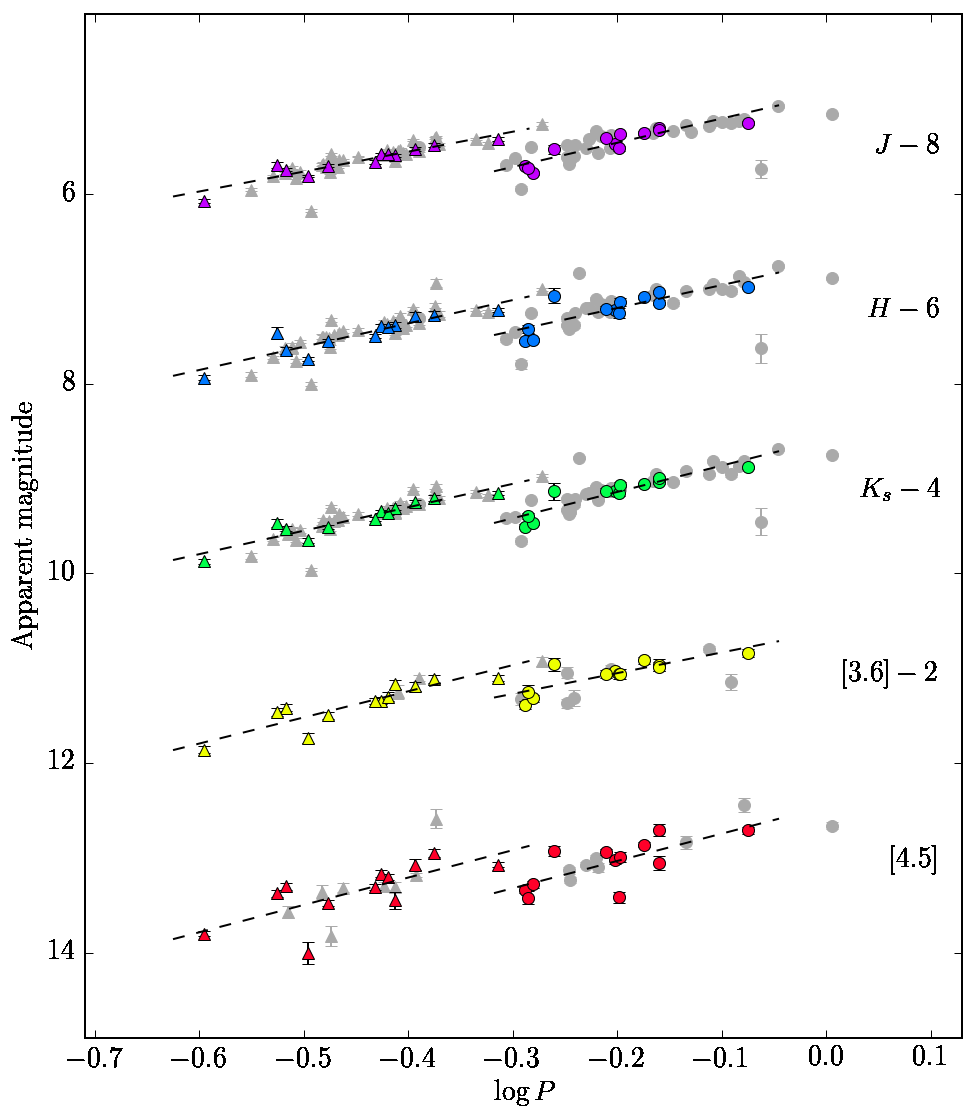

In [12]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(14.9, 4.1)
ax.set_xlim(-0.71, 0.13)

# separate full and cut sample dataframes into abs and cs
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]

slope_prior = -2.
zpt_prior = 14
#feh = -1.56749344383

per_ab = np.log10(df1_ab.per)
per_c = np.log10(df1_c.per)
xspace_ab = np.linspace(np.min(per_ab) - 0.03, np.max(per_ab) + 0.03, 100)
xspace_c = np.linspace(np.min(per_c) - 0.03, np.max(per_c) + 0.03, 100)

distance_df = {}
distance_df['wavelength'] = wavelength
distance_df['slope_ab'] = []
distance_df['slope_c'] = []
distance_df['slope_err_ab'] = []
distance_df['slope_err_c'] = []
distance_df['zpt_ab'] = []
distance_df['zpt_c'] = []
distance_df['zpt_err_ab'] = []
distance_df['zpt_err_c'] = []

for i in range(len(band_labels)):
    mag_ab = df1_ab['mag_' + band_labels[i]]
    merr_ab = df1_ab['merr_' + band_labels[i]]
    mag_c = df1_c['mag_' + band_labels[i]]
    merr_c = df1_c['merr_' + band_labels[i]]
    
    # do the fitting
    popt_ab, pcov_ab = curve_fit(fitfunc_ab, per_ab, mag_ab, p0 = [slope_prior, zpt_prior])
    popt_c, pcov_c = curve_fit(fitfunc_c, per_c, mag_c, p0 = [slope_prior, zpt_prior])
    slope_ab, slope_err_ab = popt_ab[0], np.sqrt(np.diag(pcov_ab))[0]
    zpt_ab, zpt_err_ab = popt_ab[1], np.sqrt(np.diag(pcov_ab))[1]
    slope_c, slope_err_c = popt_c[0], np.sqrt(np.diag(pcov_c))[0]
    zpt_c, zpt_err_c = popt_c[1], np.sqrt(np.diag(pcov_c))[1]
    
    distance_df['slope_ab'].append(slope_ab)
    distance_df['slope_err_ab'].append(slope_err_ab)
    distance_df['zpt_ab'].append(zpt_ab)
    distance_df['zpt_err_ab'].append(zpt_err_ab)
    distance_df['slope_c'].append(slope_c)
    distance_df['slope_err_c'].append(slope_err_c)
    distance_df['zpt_c'].append(zpt_c)
    distance_df['zpt_err_c'].append(zpt_err_c)
    
    # fit lines for plotting + get residuals
    linfit_ab = fitfunc_ab(xspace_ab, slope_ab, zpt_ab)
    #resid_ab = funcs[i*2](per_ab, dist_ab) - mag_ab
    linfit_c = fitfunc_c(xspace_c, slope_c, zpt_c)
    #resid_c = funcs[i*2 + 1](per_c, dist_c) - mag_c
    
    #df1_ab['resid_m4_' + band_labels[i]] = resid_ab
    #df1_c['resid_m4_' + band_labels[i]] = resid_c

    print band_names[i], 'ab', slope_ab, slope_err_ab, zpt_ab, zpt_err_ab
    print band_names[i], 'c', slope_c, slope_err_c, zpt_c, zpt_err_c
    
    # plot full sample in grey
    plt.errorbar(np.log10(df_ab.per), df_ab['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_ab['merr_' + band_labels[i]].values, fmt='o', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)
    plt.errorbar(np.log10(df_c.per), df_c['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_c['merr_' + band_labels[i]].values, fmt='^', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)

    #err_wtf = df_bad_ab['merr_' + band_labels[i]].values
                     
#     plt.errorbar(np.log10(df_bad_ab.per), df_bad_ab['mag_' + band_labels[i]] - mag_offset[i],
#                  yerr=df_bad_ab['merr_' + band_labels[i]].values, fmt='o', color='k',
#                  mfc='w', zorder=10)
#     plt.errorbar(np.log10(df_bad_c.per), df_bad_c['mag_' + band_labels[i]] - mag_offset[i],
#                  yerr=df_bad_c['merr_' + band_labels[i]].values, fmt='^', color='k',
#                  mfc='w', zorder=10)
    

    # plot cut sample in color
    plt.errorbar(per_ab.values, mag_ab.values - mag_offset[i], yerr=merr_ab.values, fmt='o',
                 mfc=plot_colors[i], color='k')
    plt.errorbar(per_c.values, mag_c.values - mag_offset[i], yerr=merr_c.values,
                 fmt='^', mfc=plot_colors[i], color='k')
    
    ppl.plot(xspace_ab, linfit_ab - mag_offset[i], 'k--', lw=1)
    ppl.plot(xspace_c, linfit_c - mag_offset[i], 'k--', lw=1)
    
    # add labels
    if mag_offset[i] == 0:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${}$'.format(band_names[i]), ha='right')
    else:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${} - {}$'.format(band_names[i], mag_offset[i]), ha='right')

ax.set_ylabel('Apparent magnitude')
ax.set_xlabel(r'$\log P$')
fig.tight_layout()
fig.savefig('final_plots/omegacen_pl_fits.pdf')

In [13]:
# make table of distances

# weight_ab = len(per_ab)/float(len(df1))
# weight_c = len(per_c)/float(len(df1))

# distance_df['dist_mean'] = np.asarray(distance_df['dist_ab']) * weight_ab + \
#                            np.asarray(distance_df['dist_c']) * weight_c
# distance_df['err_mean'] = np.sqrt((np.asarray(distance_df['err_ab']) * weight_ab)**2 + \
#                           (np.asarray(distance_df['err_c']) * weight_c)**2)
distance_df = pd.DataFrame.from_dict(distance_df)
distance_df = distance_df[['wavelength','slope_ab','slope_err_ab','zpt_ab','zpt_err_ab',
                           'slope_c','slope_err_c','zpt_c','zpt_err_c']]
distance_df.to_csv('final_data_files/omegacen_fit_params.csv', index=False)

In [ ]:
# incorporate residuals into full table and save

df1_withresid = pd.concat([df1_ab, df1_c])
df_withresid = df_orig.merge(df1_withresid, how='outer', on=list(set(df.keys()) & set(df1_withresid.keys())))
df_withresid.sort('id', inplace=True)
df_withresid.to_csv('final_data_files/uncrowded_withresid_m4_clipped.csv', index=False)